# Experimenting with MODIS and PACE data compared to OCx algorithm

In [1]:
1 

1

In [1]:
import scipy.io

import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import geopandas as gpd

import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
from netCDF4 import Dataset


from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

In [2]:
plt.rcParams.update({'font.size': 18})

In [3]:
auth = earthaccess.login(persist=True)

## Grab MODIS data

In [269]:
tspan = ("2020-07-01", "2020-07-01")
# tspan = ("2020-01-01", "2020-01-01")

results = earthaccess.search_data(
    short_name="MODISA_L3m_RRS",
    temporal=tspan,
    # bounding_box=bbox,
    # cloud_cover=clouds,
)

Grabbing the specific URLs we want from this list

In [270]:
modis_fns = []
for i in range(int(len(results))):
    item = results[i]['umm']['RelatedUrls'][1]['URL']
    if 'DAY' in item:
        if '4km' in item:
            if 'Rrs_' in item:
                modis_fns.append(item)
            print(item)

https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_488.4km.nc
https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_531.4km.nc
https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_547.4km.nc
https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_555.4km.nc
https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_645.4km.nc
https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_667.4km.nc
https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_678.4km.nc
https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_412.4km.nc
https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L

In [271]:
modis_fns

['https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_488.4km.nc',
 'https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_531.4km.nc',
 'https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_547.4km.nc',
 'https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_555.4km.nc',
 'https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_645.4km.nc',
 'https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_667.4km.nc',
 'https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_678.4km.nc',
 'https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3SMI/2020/0701/AQUA_MODIS.20200701.L3m.DAY.RRS.Rrs_412.4km.nc',
 'https://oceandata.sci.gsfc.nasa.gov/opendap/MODISA/L3S

In [272]:
modis_global = xr.open_mfdataset(modis_fns)

In [273]:
modis_global.Rrs_412.nbytes / 1e9

0.1492992

# open PACE

In [5]:
tspan = ("2024-07-01", "2024-07-01")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS_NRT",
    temporal=tspan,
    # bounding_box=bbox,
    # cloud_cover=clouds,
)

In [6]:
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
pace_fns = []
for i in range(len(paths)):
    if 'DAY' in str(paths[i]):
        if 'p1deg' in str(paths[i]):
            pace_fns.append(paths[i])
pace_fns

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240701.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>]

In [8]:
pace_global = xr.open_mfdataset(pace_fns)

## grab the data from Valente

In [10]:
chla_df = pd.read_csv('data/insitudb_chla_V3.tab',skiprows=28, delimiter='\t')

chla_df = chla_df.set_index('ID (idx)')

In [11]:
# rrs_df = pd.read_csv('data/insitudb_rrs_V3.tab',skiprows=969, delimiter='\t')

# rrs_df = rrs_df.set_index('ID (idx)')

In [12]:
rrs_df = pd.read_csv('data/insitudb_rrs_satbands6_V3.tab',skiprows=159, delimiter='\t')

rrs_df = rrs_df.set_index('ID (idx)')

In [13]:
rrs_df.iloc[:,np.arange(28,46,2)].median(axis=0)

Lambda [nm] (assigned to MOD1)    412.4
Lambda [nm] (assigned to MOD2)    442.1
Lambda [nm] (assigned to MOD3)    490.0
Lambda [nm] (assigned to MOD4)    530.6
Lambda [nm] (assigned to MOD5)    551.1
Lambda [nm] (assigned to MOD6)    667.7
Lambda [nm] (assigned to MOD7)    681.0
Lambda [nm] (assigned to MOD8)    748.0
Lambda [nm] (assigned to MOD9)    869.9
dtype: float64

In [14]:
wls = np.array([412.4, 442.1, 490. , 510, 555, 667.7, 681. , 748. , 869.9])

In [15]:
# wavelengths = [float(wl_str[15:-3]) for wl_str in rrs_df.columns[3:-4]]

In [16]:
# rrs_df.columns = list(rrs_df.columns[:3])+ wavelengths + list(rrs_df.columns[-4:])

In [17]:
# valente_df = pd.merge(rrs_df,chla_df)

In [18]:
# find the column closest to the intended wl that is nonnan with a tolerance of 10nm

In [19]:
# indices = []
# for w in wls:
#     indices.append(np.argmin(abs(wavelengths-w)))

In [20]:
# wl_cols = [wavelengths[i] for i in indices]

In [21]:
# valente_df.iloc[:,188-20:188+20]

In [22]:
# means = []
# for i in indices:
#     means.append(valente_df.iloc[:,i-20:i+20].mean(axis=1))

In [23]:
# valente_reduced = pd.DataFrame(np.array(means).T, columns=wls)

# now with the premade subset

In [24]:
rrs_subset = rrs_df.iloc[:,np.arange(27,45,2)]

In [25]:
rrs_subset.columns = rrs_df.iloc[:,np.arange(28,46,2)].median(axis=0).values

In [26]:
rrs_subset

,412.4,442.1,490.0,530.6,551.1,667.7,681.0,748.0,869.9
ID (idx),,,,,,,,,
1,0.005377,0.004674,0.005059,NaN,NaN,0.000432,NaN,NaN,NaN
20,0.004338,0.003396,0.003545,NaN,NaN,0.000222,NaN,NaN,NaN
23,0.004308,0.003106,0.003106,NaN,NaN,0.000204,NaN,NaN,NaN
24,0.011927,0.011094,0.010550,NaN,NaN,0.002419,NaN,NaN,NaN
67,0.006443,0.005456,0.004668,NaN,NaN,0.000139,0.000231,NaN,NaN
...,...,...,...,...,...,...,...,...,...
151669,0.010823,0.008112,0.005474,0.001950,0.001449,0.000077,0.000072,NaN,NaN
151670,0.010144,0.007727,0.005283,0.001891,0.001405,0.000077,0.000071,NaN,NaN
151671,0.011223,0.008521,0.005673,0.001982,0.001473,0.000083,0.000077,NaN,NaN


In [27]:
# trying now with the original 6 wv dataset from MODIS
valente_df = pd.merge(rrs_subset,chla_df, right_index=True, left_index=True)

In [28]:
valente_reduced = valente_df

In [29]:
# valente_reduced['HPLC'] = valente_df['Chl a [mg/m**3] (High Performance Liquid Chrom...)']
# valente_reduced['flur'] = valente_df['Chl a [mg/m**3] (Chlorophyll a, fluorometric o...)']
valente_reduced['Latitude'] = valente_df['Latitude']
valente_reduced['Longitude'] = valente_df['Longitude']

In [30]:
valente_reduced['chla'] = valente_reduced['Chl a [mg/m**3] (High Performance Liquid Chrom...)'].fillna(valente_reduced['Chl a [mg/m**3] (Chlorophyll a, fluorometric o...)'])

In [31]:
# valente_reduced.to_csv('data/valente_chla_rrs_v3.csv')

In [32]:
gdf = gpd.GeoDataFrame(
    valente_reduced, geometry=gpd.points_from_xy(valente_reduced.Longitude, valente_reduced.Latitude), crs="EPSG:4326"
)

In [ ]:
# valente_reduced['HPLC'] = valente_df['Chl a [mg/m**3] (High Performance Liquid Chrom...)']
# valente_reduced['flur'] = valente_df['Chl a [mg/m**3] (Chlorophyll a, fluorometric o...)']

In [33]:
# fig, ax = plt.subplots(figsize=(5,5))

# ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)/valente_reduced[551.1], 
#            y = valente_reduced.flur,)#c=np.nanargmax([valente_reduced[442.1],valente_reduced[490.0],valente_reduced[510]],axis=0), cmap='Set1')

# ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)/valente_reduced[551.1], 
#            y = valente_reduced.HPLC,)

# ax.set_xscale('log',base=3.333)
# ax.set_yscale('log')

# ax.set_ylabel('chla')
# ax.set_xlabel('MBR')

# ax.set_ylim(0.01,100)
# ax.set_xlim(0.3,20)

# plt.show()

# Questions to Explore

1. how representative is this of the global MODIS dataset?

2. assess more realistic uncertainties especially where we don't span
    see to what degree for the same HPLC (within uncertainty - order +/- 30%) that reflectances change
    see how far off the manifold some things fall

3. is the algorithm better is we just do matchups with Rrs

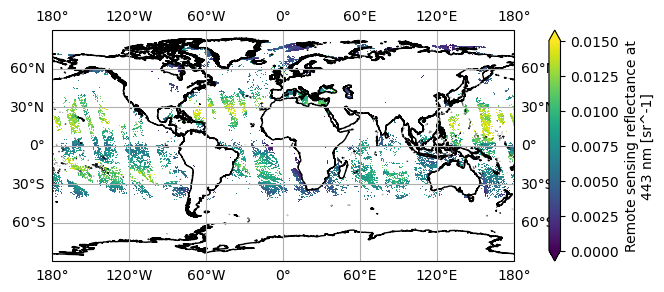

In [85]:
fig, ax = plt.subplots(figsize=(9,3), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

modis_global.Rrs_443.plot(ax=ax, x='lon', y='lat', vmin=0.00,vmax=0.015, cmap='viridis')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

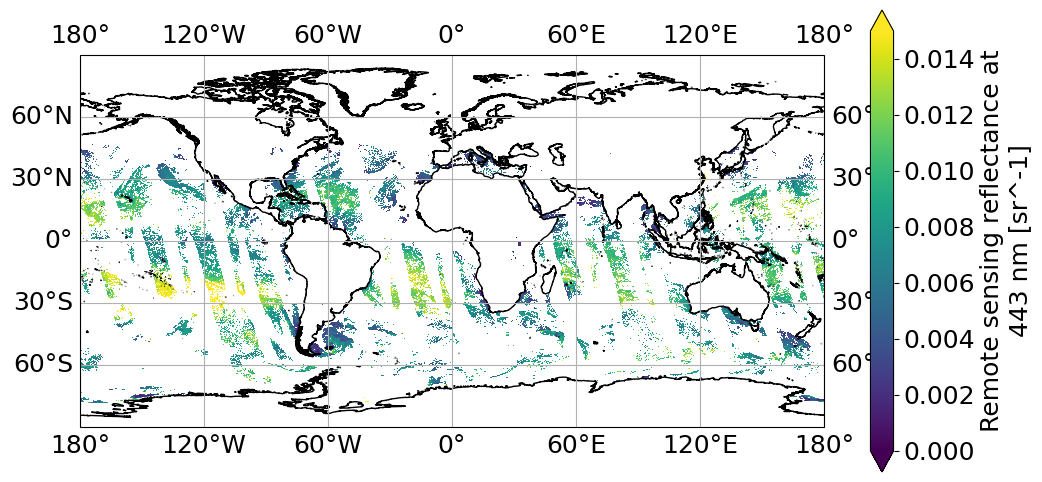

In [34]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

modis_global.Rrs_443.plot(ax=ax, x='lon', y='lat', vmin=0.00,vmax=0.015, cmap='viridis')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

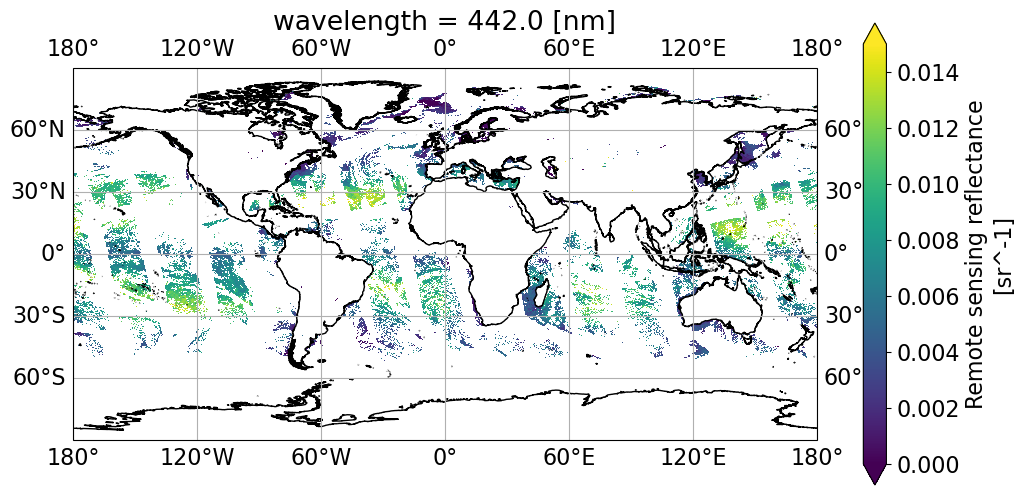

In [248]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

dataset.Rrs[:,:,42].plot(ax=ax, x='lon', y='lat', vmin=0.00,vmax=0.015, cmap='viridis')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

/tmp/ipykernel_760/3567260172.py:3: RuntimeWarning: All-NaN axis encountered
  ax.hist(np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)/valente_reduced[555], label='Valente')
/tmp/ipykernel_760/3567260172.py:5: RuntimeWarning: All-NaN axis encountered
  ax.hist(np.nanmax([dataset_oc.Rrs_443.values.flatten()[::1500],


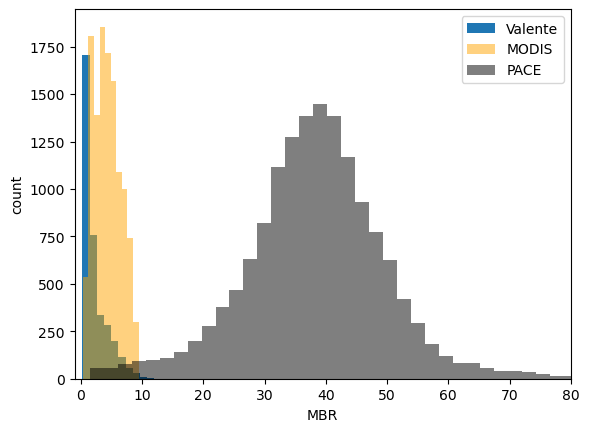

In [178]:
skip_num = 1
fig,ax= plt.subplots()
ax.hist(np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)/valente_reduced[555], label='Valente')

ax.hist(np.nanmax([dataset_oc.Rrs_443.values.flatten()[::1500],
                       dataset_oc.Rrs_488.values.flatten()[::1500]],axis=0)/dataset_oc.Rrs_555.values.flatten()[::1500],color='orange',alpha=0.5, label='MODIS')

ax.hist(np.nanmax([
    dataset.Rrs[:,:,42].values.flatten()[::skip_num],
    dataset.Rrs[:,:,60].values.flatten()[::skip_num]])/
         dataset.Rrs[:,:,87].values.flatten()[::skip_num],
         color='black',alpha=0.5, label='PACE',bins=45)

ax.legend(loc='upper right')
ax.set_xlabel('MBR')

ax.set_xlim(-1,80)

# ax.set_yscale('log')

ax.set_ylabel('count')

# plt.savefig('figs/MBR_comparison_modis_pace_valente.png',dpi=300)

plt.show()

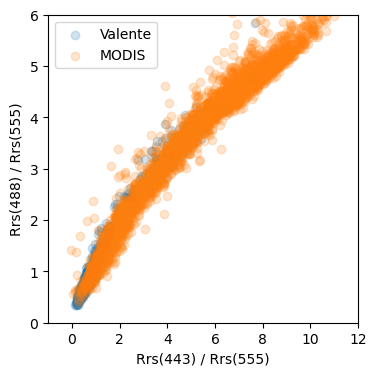

In [88]:
skip_num = 1000
# Rrs443/Rrs555 vs. Rrs490/Rrs555

fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(valente_reduced[442.1]/valente_reduced[551.1], valente_reduced[490.0]/valente_reduced[551.1],alpha=0.2, label='Valente')

ax.scatter(modis_global.Rrs_443.values.flatten()[::skip_num]/modis_global.Rrs_555.values.flatten()[::skip_num], 
            modis_global.Rrs_488.values.flatten()[::skip_num]/modis_global.Rrs_555.values.flatten()[::skip_num],alpha=0.2, label='MODIS')

ax.set_xlabel('Rrs(443) / Rrs(555)')
ax.set_ylabel('Rrs(488) / Rrs(555)')

ax.legend()

ax.set_xlim(-1,12)
ax.set_ylim(0,6)

# plt.savefig('figs/phase_comparison_modis_valente.png',dpi=300)


plt.show()

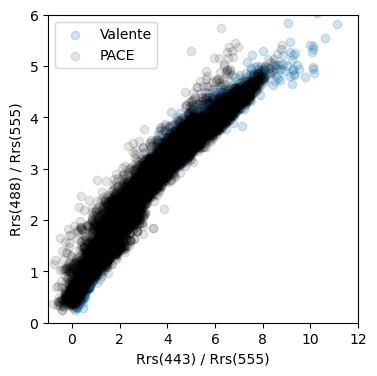

In [131]:
# Rrs443/Rrs555 vs. Rrs490/Rrs555

fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(valente_reduced[442.1]/valente_reduced[555], valente_reduced[490.0]/valente_reduced[555],alpha=0.2,label='Valente')

ax.scatter(dataset.Rrs[:,:,42].values.flatten()[::skip_num]/dataset.Rrs[:,:,84].values.flatten()[::skip_num], 
            dataset.Rrs[:,:,60].values.flatten()[::skip_num]/dataset.Rrs[:,:,84].values.flatten()[::skip_num],alpha=0.1, label='PACE',c='black')

ax.set_xlabel('Rrs(443) / Rrs(555)')
ax.set_ylabel('Rrs(488) / Rrs(555)')

ax.set_xlim(-1,12)
ax.set_ylim(0,6)

ax.legend()

plt.savefig('figs/phase_comparison_pace_valente.png',dpi=300)

plt.show()

In [63]:
# Comparing the Rrs in green and blue

In [35]:
modis_global

<xarray.Dataset> Size: 1GB
Dimensions:  (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    palette  (rgb, eightbitcolor) int8 768B dask.array<chunksize=(3, 256), meta=np.ndarray>
    Rrs_412  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_443  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_469  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_488  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_531  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_547  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_555  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_645  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_667  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_678  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20200101.L3m.DAY.RRS.Rrs_412...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Optics >...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        Attribute elided: Unsupported attribute...
    data_minimum:                     -0.0034379999
    data_maximum:                     0.06296955

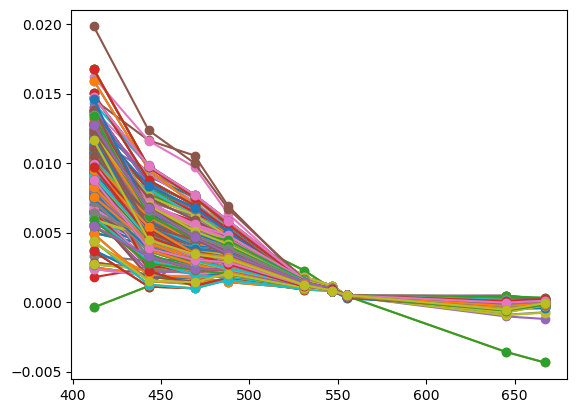

In [118]:
plt.plot([412, 443, 469, 488, 531, 547, 555,645, 667],np.array([modis_global.Rrs_412.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_443.values[modis_global.Rrs_555.values < 0.0005], 
                                 modis_global.Rrs_469.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_488.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_531.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_547.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_555.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_645.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_667.values[modis_global.Rrs_555.values < 0.0005]]),
         marker='o')
plt.show()

In [37]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0
    
x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)
y = valente_reduced[551.1].values

pts = np.array([x,y])
pts = pts.T[~np.isnan(pts).any(axis=0)]

# go through the points, if they don't have a neighbor within 30% of their value then throw them out, then make a convex hull

import math
def get_dist(a,b):
  return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

np_list = []
for i in range(len(pts)):
    dist = math.inf #(infinity)
    npidx = 0
    for j in range(len(pts)):
       d = get_dist(pts[i],pts[j])
       if d<dist and d!=0: # to avoid the same point
          dist =d
          npidx = j
    np_list.append(dist)

mean_val = pts.mean(axis=1)

dist_ratio = np_list/mean_val
dist_ratio[dist_ratio > 0.3]

/tmp/ipykernel_125/2944198737.py:16: RuntimeWarning: All-NaN axis encountered
  x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)


array([0.31491375, 0.81345096, 1.28377256, 3.48624781])

/tmp/ipykernel_125/752308539.py:15: RuntimeWarning: All-NaN axis encountered
  ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),


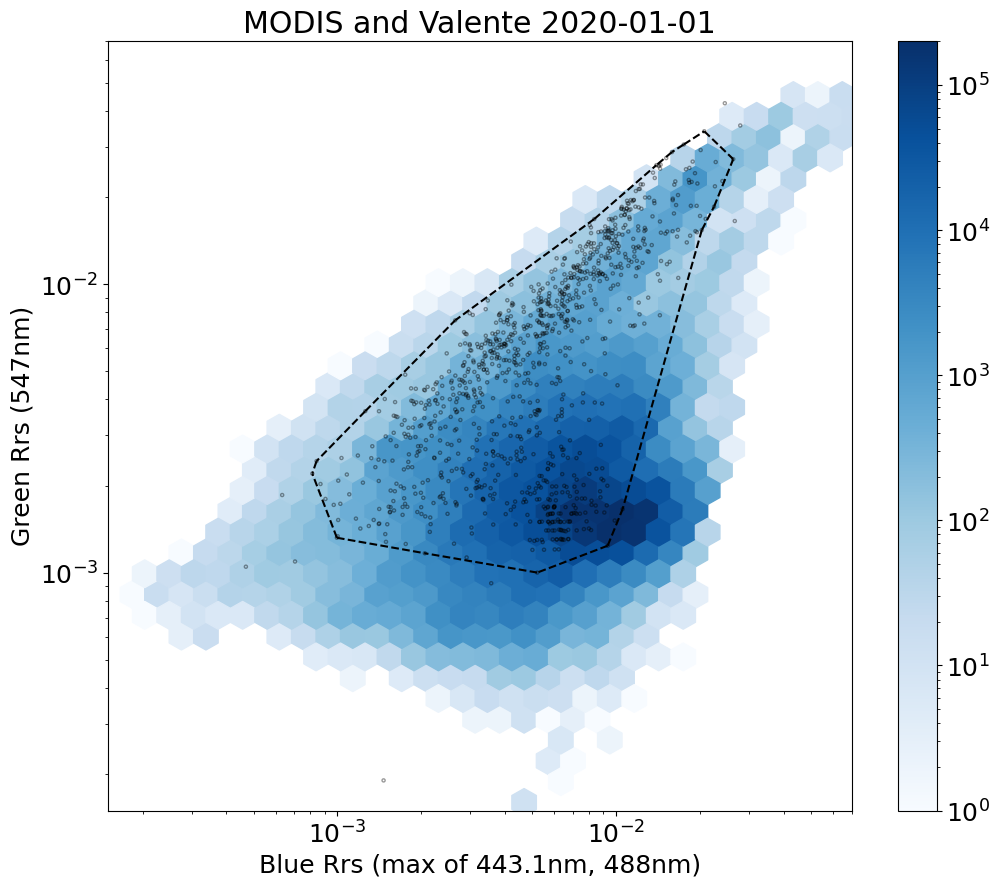

In [40]:
skip_num = 1

fig, ax = plt.subplots(figsize=(12,10))

hb = ax.hexbin(x = np.max([modis_global.Rrs_443.values.flatten()[::skip_num],
                       modis_global.Rrs_488.values.flatten()[::skip_num]],axis=0), 
           y = modis_global.Rrs_555.values.flatten()[::skip_num],
          yscale='log',xscale='log',
         gridsize=30,
          bins='log',
         cmap='Blues')

fig.colorbar(hb)

ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),
           y = valente_reduced[551.1], facecolor='none', edgecolor='k', alpha=0.4, label='Valente',s=5)

from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

for simplex in hull.simplices:
    ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')

# ax.scatter(x=pts[:,0],y=pts[:,1])
# ax.scatter(x=pts[:,0][dist_ratio > 0.2],y=pts[:,1][dist_ratio > 0.2])

ax.set_ylim(0.00015,0.07)
ax.set_xlim(0.00015,0.07)


# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('Blue Rrs (max of 443.1nm, 488nm)')
ax.set_ylabel('Green Rrs (547nm)')

ax.set_title('MODIS and Valente 2020-01-01')

plt.savefig('figs/modis_winter_valente_density.png',dpi=600)

plt.show()



/tmp/ipykernel_125/114002327.py:15: RuntimeWarning: All-NaN axis encountered
  ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),


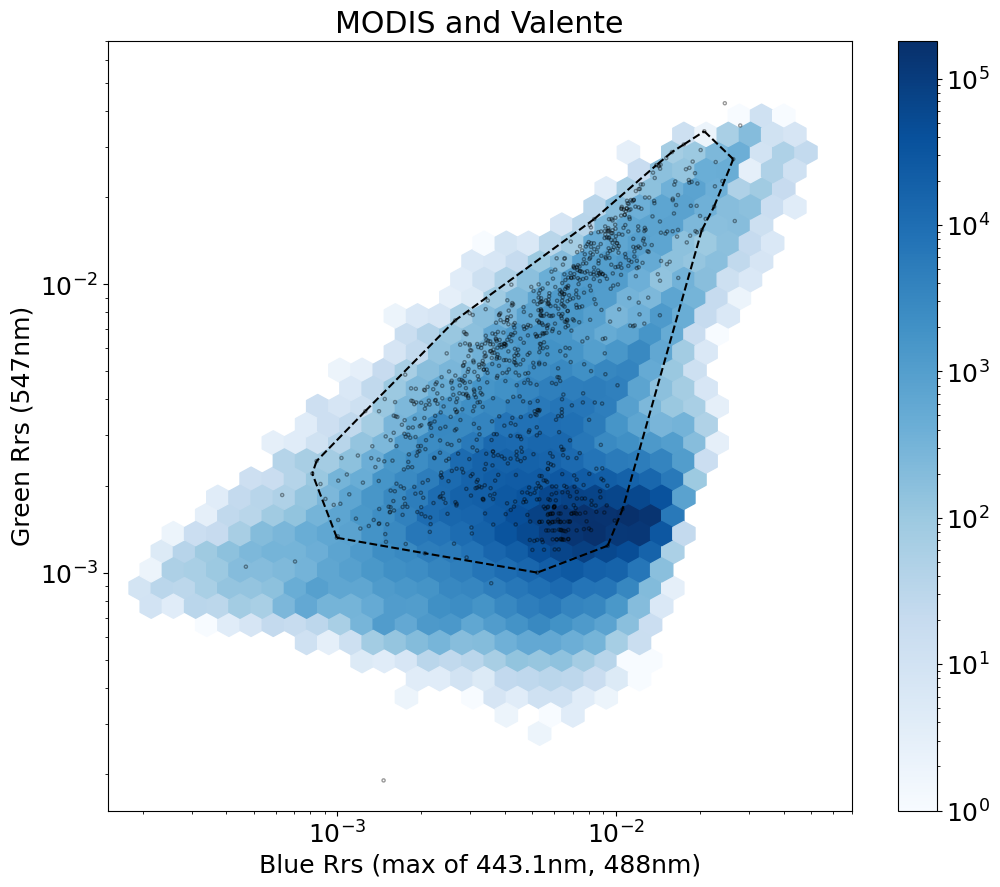

In [274]:
skip_num = 1

fig, ax = plt.subplots(figsize=(12,10))

hb = ax.hexbin(x = np.max([modis_global.Rrs_443.values.flatten()[::skip_num],
                       modis_global.Rrs_488.values.flatten()[::skip_num]],axis=0), 
           y = modis_global.Rrs_555.values.flatten()[::skip_num],
          yscale='log',xscale='log',
         gridsize=30,
          bins='log',
         cmap='Blues')

fig.colorbar(hb)

ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),
           y = valente_reduced[551.1], facecolor='none', edgecolor='k', alpha=0.4, label='Valente',s=5)

from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

for simplex in hull.simplices:
    ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')

# ax.scatter(x=pts[:,0],y=pts[:,1])
# ax.scatter(x=pts[:,0][dist_ratio > 0.2],y=pts[:,1][dist_ratio > 0.2])

ax.set_ylim(0.00015,0.07)
ax.set_xlim(0.00015,0.07)


# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('Blue Rrs (max of 443.1nm, 488nm)')
ax.set_ylabel('Green Rrs (547nm)')

ax.set_title('MODIS and Valente')

plt.savefig('figs/modis_summer_valente_density.png',dpi=600)

plt.show()

Build the MODIS points to compare

In [275]:
modis_pts = np.array([np.nanmax([modis_global.Rrs_443.values.flatten(),modis_global.Rrs_488.values.flatten()],axis=0), modis_global.Rrs_555.values.flatten()]).T
points_in_hull = in_hull(modis_pts,pts[dist_ratio < 0.2])

/tmp/ipykernel_125/1844822763.py:1: RuntimeWarning: All-NaN axis encountered
  modis_pts = np.array([np.nanmax([modis_global.Rrs_443.values.flatten(),modis_global.Rrs_488.values.flatten()],axis=0), modis_global.Rrs_555.values.flatten()]).T


In [276]:
points_in_hull = points_in_hull.astype(np.float16)

In [277]:
points_in_hull[np.isnan(modis_pts[:,0])] = np.nan

In [278]:
np.unique(points_in_hull, return_counts=True)

(array([ 0.,  1., nan], dtype=float16), array([ 1081636,  2468198, 33774966]))

In [183]:
np.unique(points_in_hull, return_counts=True)

(array([ 0.,  1., nan], dtype=float16), array([ 1037361,  2287763, 33999676]))

In [180]:
modis_global["in_hull"]=(['lat', 'lon'],  clusters.reshape(4320,8640))

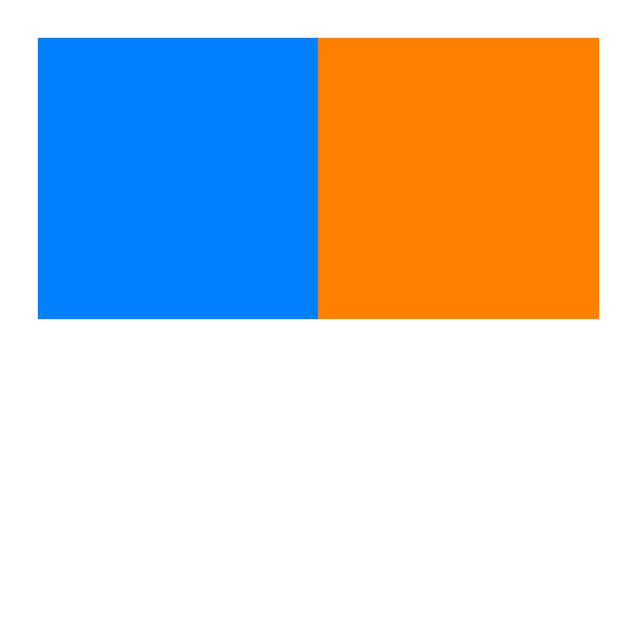

In [181]:
import distinctipy
N=2
colours = distinctipy.get_colors(N, colorblind_type='Deuteranomaly',rng=30)

distinctipy.color_swatch(colours)

distincti_cmap_bi = distinctipy.get_colormap(colours)

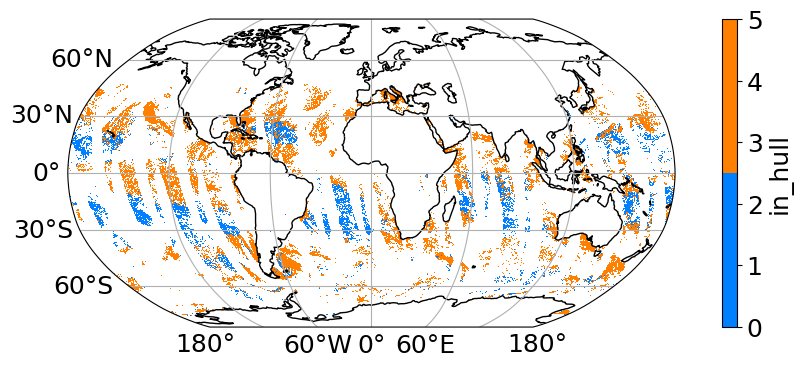

In [184]:
fig, ax = plt.subplots(figsize=(12,4), subplot_kw=dict(projection=crs.Robinson()))

ax.coastlines()
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

modis_global.in_hull.plot(ax=ax, x='lon', y='lat', cmap=distincti_cmap_bi, transform=crs.PlateCarree())

gl = ax.gridlines(draw_labels=True)

gl.top_labels = False
gl.right_labels = False

plt.savefig('figs/modis_winter_outside_insitu_hull.png',dpi=300)

plt.show()

In [32]:
pace_global

<xarray.Dataset> Size: 5GB
Dimensions:     (wavelength: 184, lat: 1800, lon: 3600, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 339.0 341.0 344.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 5GB dask.array<chunksize=(16, 1024, 8), meta=np.ndarray>
    palette     (rgb, eightbitcolor) uint8 768B dask.array<chunksize=(3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240701.L3m.DAY.RRS.V2_0.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/2.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         748293
    data_minimum:                      -0.010000003
    data_maximum:                      0.10000001

In [32]:
pace_global.load()

<xarray.Dataset> Size: 5GB
Dimensions:     (wavelength: 184, lat: 1800, lon: 3600, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 339.0 341.0 344.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 5GB nan nan nan ... nan nan nan
    palette     (rgb, eightbitcolor) uint8 768B 147 0 108 144 0 ... 0 0 0 0 0
Attributes: (12/64)
    product_name:                      PACE_OCI.20240701.L3m.DAY.RRS.V2_0.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/2.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         748293
    data_minimum:                      -0.010000003
    data_maximum:                      0.10000001

<timed exec>:15: RuntimeWarning: All-NaN axis encountered


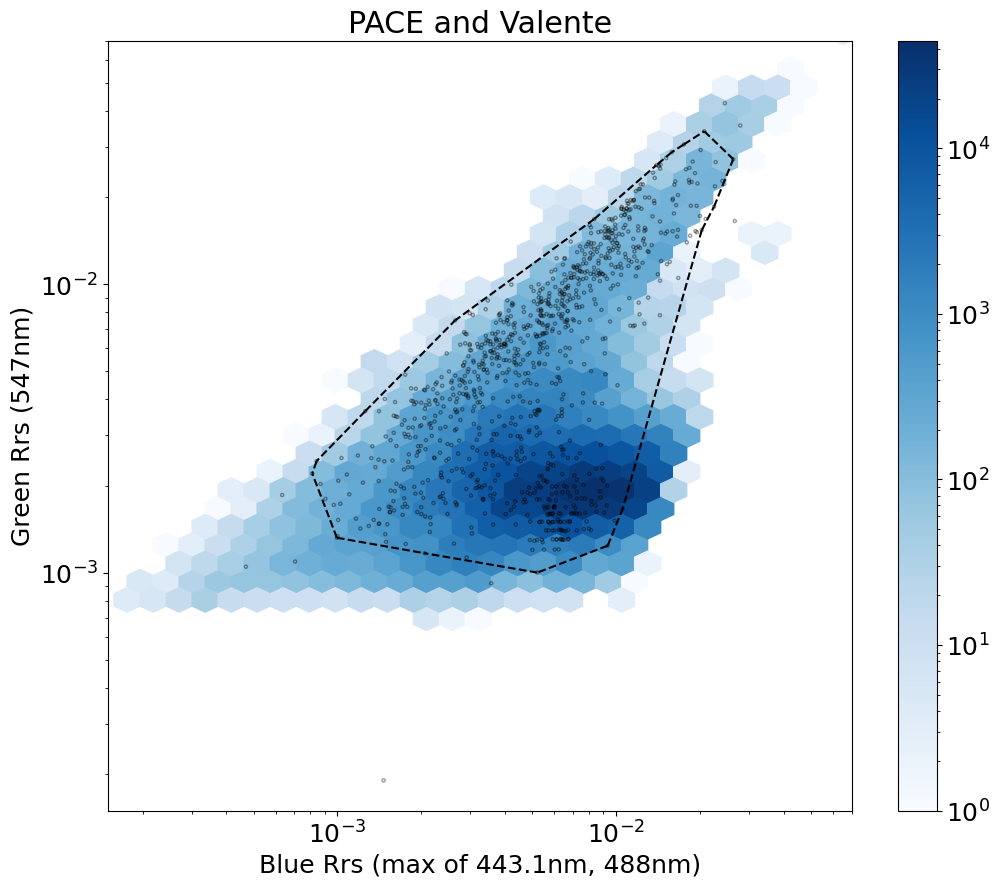

CPU times: user 3.57 s, sys: 143 ms, total: 3.71 s
Wall time: 3.8 s


In [39]:
%%time
skip_num = 1

fig, ax = plt.subplots(figsize=(12,10))

hb = ax.hexbin(x = np.max([pace_global.Rrs[:,:,42].values.flatten()[::skip_num],
                       pace_global.Rrs[:,:,60].values.flatten()[::skip_num]],axis=0), 
           y = pace_global.Rrs[:,:,84].values.flatten()[::skip_num],
          yscale='log',xscale='log',
         gridsize=30,
          bins='log',
         cmap='Blues')

fig.colorbar(hb)

ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),
           y = valente_reduced[551.1], facecolor='none', edgecolor='k', alpha=0.4, label='Valente',s=5)

ax.set_ylim(0.00015,0.07)
ax.set_xlim(0.00015,0.07)

from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

for simplex in hull.simplices:
    ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')


# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('Blue Rrs (max of 443.1nm, 488nm)')
ax.set_ylabel('Green Rrs (547nm)')

ax.set_title('PACE and Valente')

plt.savefig('figs/pace_valente_density.png',dpi=600)

plt.show()

In [40]:
pace_pts = np.array([np.max([pace_global.Rrs[:,:,42].values.flatten(),pace_global.Rrs[:,:,60].values.flatten()],axis=0),pace_global.Rrs[:,:,84].values.flatten()]).T

In [41]:
pace_pts[::1000].shape

(6480, 2)

In [44]:
points_in_hull = in_hull(pace_pts[::1],pts[dist_ratio < 0.2])

In [53]:
np.unique(points_in_hull, return_counts=True)

(array([False,  True]), array([5841029,  638971]))

In [46]:
pace_global.Rrs[:,:,42]

<xarray.DataArray 'Rrs' (lat: 1800, lon: 3600)> Size: 26MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    wavelength  float64 8B 442.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Attributes:
    long_name:      Remote sensing reflectance
    units:          sr^-1
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    valid_min:      -30000
    valid_max:      25000
    display_scale:  linear
    display_min:    0.0
    display_max:    0.025

In [54]:
pace_pts.shape

(6480000, 2)

In [62]:
points_in_hull[np.isnan(pace_pts[:,0])] = pace_pts[:,0][np.isnan(pace_pts[:,0])]

In [94]:
points_in_hull = points_in_hull.astype(np.int8)

In [88]:
points_in_hull[np.isnan(pace_pts[:,0])] = -1

In [89]:
np.unique(points_in_hull,return_counts=True)

(array([-1.,  0.,  1.], dtype=float16), array([5731707,  109322,  638971]))

In [95]:
pace_global["in_hull"]=(['lat', 'lon'],  points_in_hull.reshape(1800,3600))

In [96]:
pace_global["in_hull"]

<xarray.DataArray 'in_hull' (lat: 1800, lon: 3600)> Size: 6MB
array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0

In [178]:
fig, ax = plt.subplots(figsize=(16,5), subplot_kw=dict(projection=crs.Robinson()))

ax.coastlines()
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

pace_global["in_hull"].plot(ax=ax, x='lon', y='lat', cmap=distincti_cmap_bi, transform=crs.PlateCarree())
# modis_subset.Rrs_443.plot(ax=ax, x='lon', y='lat', vmin=0.00,vmax=0.015, cmap='Reds', transform=crs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


plt.savefig('figs/pace_outside_insitu_hull.png',dpi=300)

plt.show()

In [97]:
pace_global.to_netcdf('data/pace_with_hull.nc')

### Cluster the MODIS data based on just blue and green

In [59]:
from sklearn.cluster import KMeans

In [60]:
1

1

In [203]:
modis_pts.shape

(37324800, 2)

In [62]:
modis_pts[~np.isnan(modis_pts).any(axis=1)].shape

(3325124, 2)

In [ ]:
0.002, 0.002

In [166]:
clusters = np.zeros(modis_pts.shape[0])

In [167]:
clusters[modis_pts[:,1] < 0.004] = 5
clusters[modis_pts[:,1] < 0.001] = 4
clusters[(modis_pts[:,0] > 0.01) & (modis_pts[:,1] < 0.008)] = 2
clusters[(modis_pts[:,0] > 0.01) & (modis_pts[:,1] < 0.002)] = 1
clusters[(modis_pts[:,0] < 0.002) & (modis_pts[:,1] < 0.004)] = 3

In [168]:
clusters[np.isnan(modis_pts).any(axis=1)] = np.nan

In [169]:
np.unique(clusters,return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5., nan]),
 array([   63324,   772918,   152546,    30585,   110364,  2195387,
        33999676]))

In [170]:
! pip install distinctipy

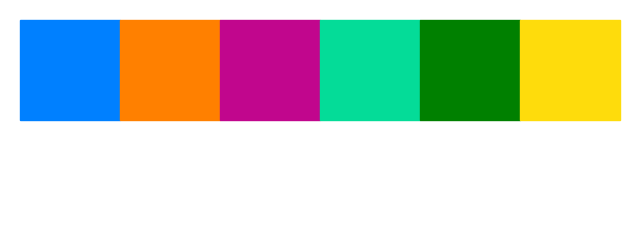

In [171]:
import distinctipy
N=6
colours = distinctipy.get_colors(N, colorblind_type='Deuteranomaly',rng=30)

distinctipy.color_swatch(colours)

distincti_cmap = distinctipy.get_colormap(colours)

In [172]:
1

1

/tmp/ipykernel_125/4147534972.py:9: RuntimeWarning: All-NaN axis encountered
  ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),


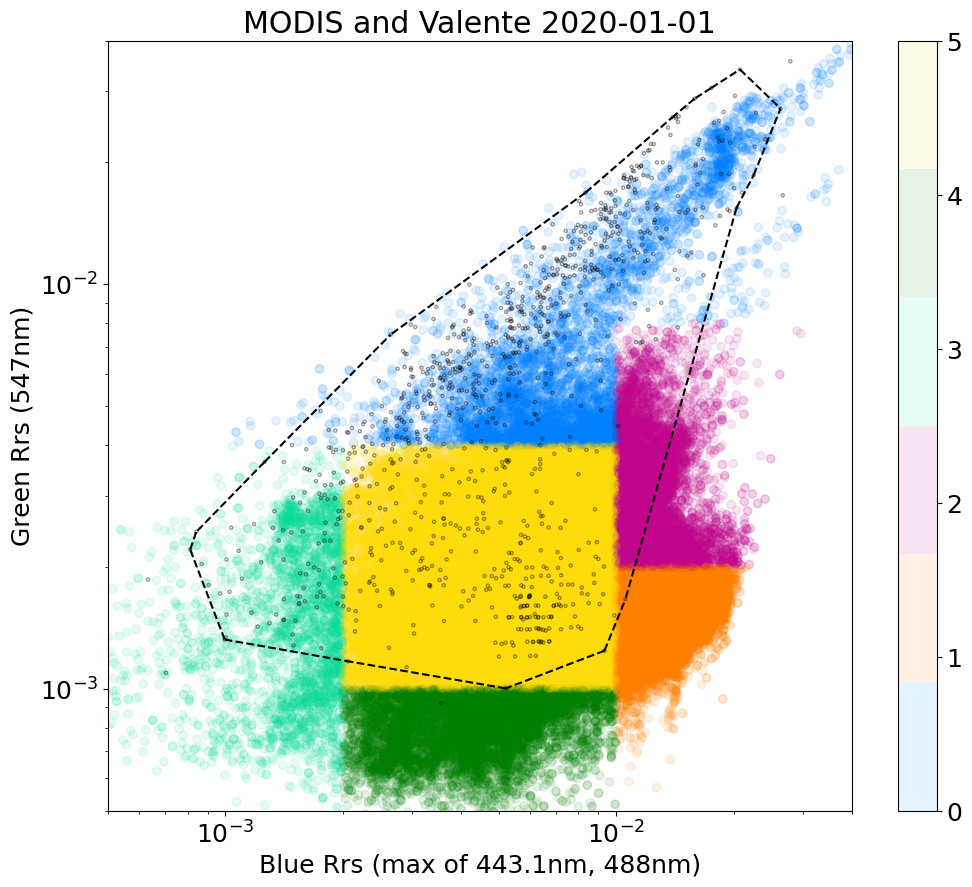

In [179]:
skip_num = 1

fig, ax = plt.subplots(figsize=(12,10))

cm = ax.scatter(modis_pts[::10,0],modis_pts[::10,1],c=clusters[::10],alpha=0.1, cmap=distincti_cmap)

fig.colorbar(cm)

ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),
           y = valente_reduced[551.1], facecolor='none', edgecolor='k', alpha=0.4, label='Valente',s=5)

from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

for simplex in hull.simplices:
    ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')

# ax.scatter(x=pts[:,0],y=pts[:,1])
# ax.scatter(x=pts[:,0][dist_ratio > 0.2],y=pts[:,1][dist_ratio > 0.2])

ax.set_ylim(0.0005,0.04)
ax.set_xlim(0.0005,0.04)


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Blue Rrs (max of 443.1nm, 488nm)')
ax.set_ylabel('Green Rrs (547nm)')

ax.set_title('MODIS and Valente 2020-01-01')

plt.savefig('figs/modis_clusters.png',dpi=600)

plt.show()

In [174]:
modis_global["cluster"]=(['lat', 'lon'],  clusters.reshape(4320,8640))

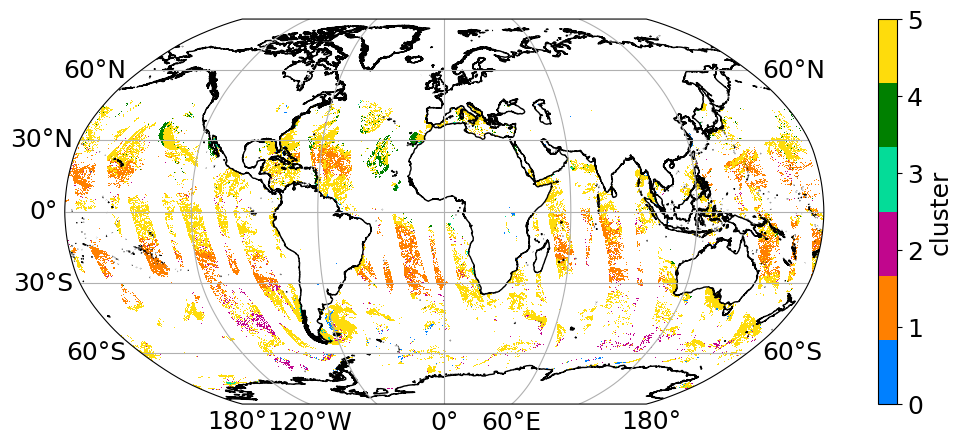

In [175]:
fig, ax = plt.subplots(figsize=(14,5), subplot_kw=dict(projection=crs.Robinson()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

modis_global.cluster.plot(ax=ax, x='lon', y='lat', cmap=distincti_cmap, transform=crs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.savefig('figs/modis_clusters_from_undersampling.png',dpi=600)

plt.show()

### Calculate the min distance to the nearest in situ point

In [228]:
len(modis_pts) / 1e6

37.3248

In [229]:
from scipy.spatial import distance_matrix

In [248]:
dist_mat = distance_matrix(modis_pts_subset,pts_subset)

In [250]:
np.min(dist_mat,axis=0)

array([3.24634098e-04, 4.80097740e-05, 2.16014577e-05, ...,
       1.55069747e-05, 3.69956670e-06, 1.07911278e-04])

In [234]:
modis_pts_subset = modis_pts[~np.isnan(modis_pts).any(axis=1)]
pts_subset = pts[dist_ratio < 0.2]

In [268]:
dist_ratio.shape

(1024,)

In [267]:
pts_subset.shape

(1014, 2)

In [251]:
min_dists = []
for i in range(len(modis_pts_subset)):
    min_dists.append(np.min(np.linalg.norm(modis_pts_subset[i]-pts_subset,axis=1)))

IndexError: index 3325124 is out of bounds for axis 0 with size 3325124

In [252]:
i

3325124

In [253]:
min_dists = np.array(min_dists)

In [261]:
min(min_dists)

7.416244056223401e-08

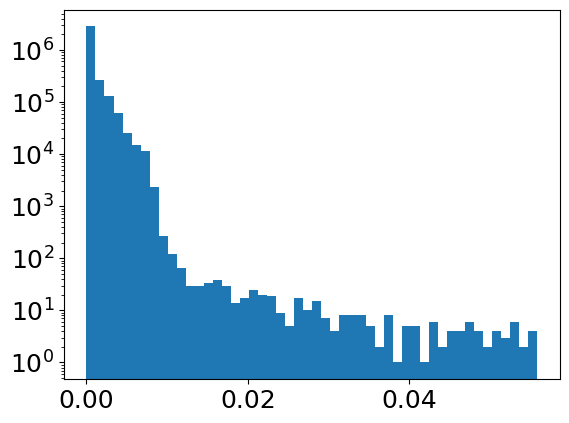

In [256]:
plt.hist(min_dists, bins=50)
plt.yscale('log')
plt.show()

In [257]:
modis_min_dists = np.zeros(modis_pts.shape[0])
modis_min_dists[np.isnan(modis_pts).any(axis=1)] = np.nan
modis_min_dists[~np.isnan(modis_pts).any(axis=1)] = min_dists

In [258]:
modis_global["min_dists"]=(['lat', 'lon'],  modis_min_dists.reshape(4320,8640))

In [260]:
import matplotlib

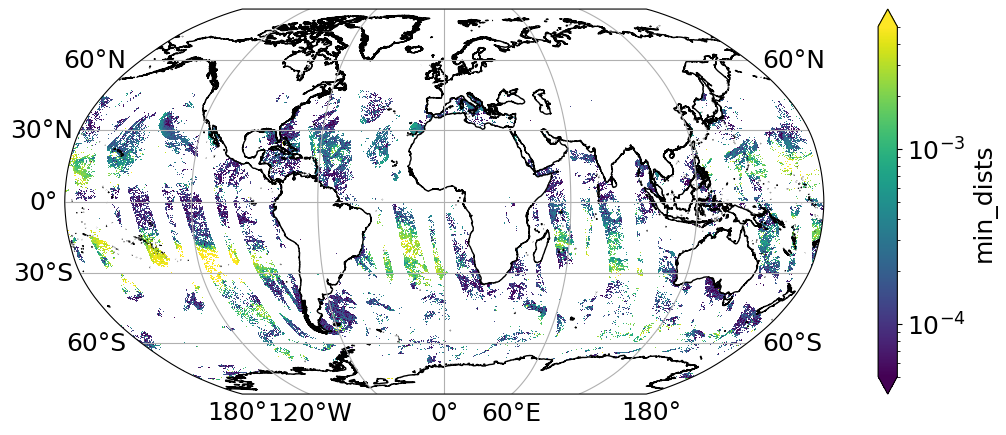

In [265]:
fig, ax = plt.subplots(figsize=(14,5), subplot_kw=dict(projection=crs.Robinson()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

modis_global.min_dists.plot(ax=ax, x='lon', y='lat', cmap='viridis', transform=crs.PlateCarree(), norm=matplotlib.colors.LogNorm(vmin=0.00005, vmax=0.005))

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.savefig('figs/modis_min_dists.png',dpi=600)

plt.show()